# Natural Language Processing
## Assignment 2: 번역 모델 전처리

### 0. Introduction

- 본 과제의 목적은 영어-한글 번역 모델을 학습하기 위해 영어-한글 번역 데이터셋을 전처리하는 방법을 학습하는 것입니다. 이번 과제에서는 번역 모델의 입/출력을 만들기 위해 자주 사용되는 여러가지 자연어 전처리 기술을 익히게 됩니다. 번역 모델은 번역하고자 하는 문장(Source)을 입력으로 받고, 번역 결과(Target)을 출력합니다.<br><br>
- 미완성된 함수 3개가 있습니다. (preprocess, collate_fn, bucketing) 아래의 지시 사항과 각 함수의 docstring을 참고하여 함수 3개를 완성하여 Data Loader를 완성해주세요. test case를 모두 통과해야 합니다.

In [2]:
from typing import List, Dict, Tuple, Sequence, Any
from collections import Counter, defaultdict, OrderedDict
from itertools import chain
import random
random.seed(1234)

import torch

In [3]:
class Language(Sequence[List[str]]):
    PAD_TOKEN = '<PAD>'
    PAD_TOKEN_IDX = 0
    UNK_TOKEN = '<UNK>'
    UNK_TOKEN_IDX = 1
    SOS_TOKEN = '<SOS>'
    SOS_TOKEN_IDX = 2
    EOS_TOKEN = '<EOS>'
    EOS_TOKEN_IDX = 3

    def __init__(self, sentences: List[str]) -> None:
        self._sentences: List[List[str]] = [sentence.split() for sentence in sentences]

        self.word2idx: Dict[str, int] = None
        self.idx2word: List[str] = None
    
    def build_vocab(self, min_freq: int=1) -> None:
        SPECIAL_TOKENS: List[str] = [Language.PAD_TOKEN, Language.UNK_TOKEN, Language.SOS_TOKEN, Language.EOS_TOKEN]
        self.idx2word = SPECIAL_TOKENS + [word for word, count in Counter(chain(*self._sentences)).items() if count >= min_freq] # items() 뽑으면 : (ex) dict_items([('나는', 1), ('남는', 1), ('시간에', 1), ('공부를', 1), ('한다', 1), ('우리는', 1), ('언제나', 1), ('서로에 게', 1), ('사랑을', 1), ('보여주려', 1), ('노력해요', 1)])
        self.word2idx = {word: idx for idx, word in enumerate(self.idx2word)}
    
    def set_vocab(self, word2idx: Dict[str, int], idx2word: List[str]) -> None:
        self.word2idx = word2idx
        self.idx2word = idx2word
    
    def __getitem__(self, index: int) -> List[str]:
        return self._sentences[index]
    
    def __len__(self) -> int:
        return len(self._sentences)


class NMTDataset(Sequence[Tuple[List[int], List[int]]]):
    def __init__(self, src: Language, tgt: Language, max_len: int=30) -> None:
        assert len(src) == len(tgt)
        assert src.word2idx is not None and tgt.word2idx is not None

        self._src = src
        self._tgt = tgt
        self._max_len = max_len

    def __getitem__(self, index: int) -> Tuple[List[str], List[str]]:
        return preprocess(self._src[index], self._tgt[index], self._src.word2idx, self._tgt.word2idx, self._max_len)

    def __len__(self) -> int:
        return len(self._src)

### 1. Sentence Preprocessor

- NLP 모델에 자연어 정보를 전달하기 위해서는 적절한 형태로의 전처리가 필요합니다. 주어진 데이터셋은 Source, Target(한->영 번역의 경우 source는 한국어 문장, target은 영어 문장이 됩니다.) 각각 하나의 문장으로 이루어져 있고 모델에 해당 정보를 전달하기 위해서는 하나의 문장을 여러 단어로 분리하고 각각의 단어를 index로 바꿔줄 수 있는 word2idx dictionary가 필요합니다(동일한 단어 = 동일한 index). 

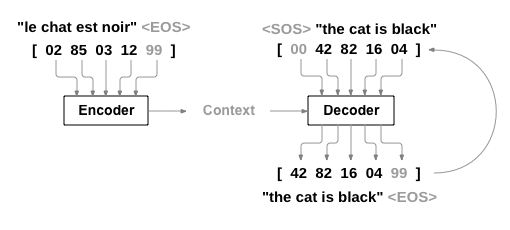

해당 과정은 가장 간단한 수준의 tokenization이며 거의 모든 자연어 전처리 과정에서 사용됩니다. 주어진 문장쌍(Source, Target)을 단어 index 단위로 바꾸어주는 preprocess 함수를 docstring을 참고하여 완성해주세요.<br><br>
- **추가사항**: 번역 모델에서 Target 문장에는 sos(start of sentence), eos(end of sentence) token이 추가되고 각각은 문장의 시작과 끝을 알려주는 token으로 사용됩니다. (그림 참고)

In [4]:
def preprocess(
    raw_src_sentence: List[str],
    raw_tgt_sentence: List[str],
    src_word2idx: Dict[str, int],
    tgt_word2idx: Dict[str, int],
    max_len: int
) -> Tuple[List[int], List[int]]:
    """ Sentence preprocessor for neural machine translation

    Preprocess Rules:
    1. All words should be converted into their own index number by word2idx.
    2. If there is no matched word in word2idx, you should replace the word as <UNK> token.
    3. You have to use matched word2idx for each source/target language.
    4. You have to insert <SOS> as the first token of the target sentence.
    5. You have to insert <EOS> as the last token of the target sentence.
    6. The length of preprocessed sentences should not exceed max_len.
    7. If the lenght of the sentence exceed max_len, you must truncate the sentence.

    Arguments:
    raw_src_sentence -- raw source sentence without any modification
    raw_tgt_sentence -- raw target sentence without any modification 
    src_word2idx -- dictionary for source language which maps words to their unique numbers
    tgt_word2idx -- dictionary for target language which maps words to their unique numbers
    max_len -- maximum length of sentences

    Return:
    src_sentence -- preprocessed source sentence
    tgt_sentence -- preprocessed target sentence

    """
    # Special tokens, use these notations if you want
    UNK = Language.UNK_TOKEN_IDX
    SOS = Language.SOS_TOKEN_IDX
    EOS = Language.EOS_TOKEN_IDX

    ## 아래에 코드 빈칸(None)을 완성해주세요
    src_sentence = []
    tgt_sentence = []
    for word in raw_src_sentence:
        if word in src_word2idx: # src dictionary에 현재의 word가 있는 경우
            src_sentence.append(src_word2idx[word])
        else:
            src_sentence.append(UNK) # src dictionary에 현재의 word가 없는 경우
    
    for word in raw_tgt_sentence:
        if word in tgt_word2idx: # tgt dictionary에 현재의 word가 있는 경우
            tgt_sentence.append(tgt_word2idx[word])
        else:
            tgt_sentence.append(UNK) # tgt dictionary에 현재의 word가 없는 경우

    # [선택] try, except을 활용해서 조금 더 빠르게 동작하는 코드를 작성해보세요.
    # for word in raw_src_sentence:
    #     try:
    #         src_sentence.append(src_word2idx[word])
    #     except:
    #         src_sentence.append(UNK)
    # for word in raw_tgt_sentence:
    #     try: 
    #         tgt_sentence.append(tgt_word2idx[word])
    #     except:
    #         tgt_sentence.append(UNK)

    # [선택] List Comprehension을 활용해서 짧은 코드를 작성해보세요. (~2 lines)
    # src_sentence=[src_word2idx[word] if word in src_word2idx else UNK for word in raw_src_sentence]
    # tgt_sentence=[tgt_word2idx[word] if word in tgt_word2idx else UNK for word in raw_tgt_sentence]
    

    src_sentence = src_sentence[:max_len] # max_len까지의 sequence만
    tgt_sentence = [SOS] + tgt_sentence[:max_len-2] + [EOS] # SOS, EOS token을 추가하고 max_len까지의 sequence만 - SOS/EOS 포함해서 max_len인듯

    ### 코드 작성 완료
    return src_sentence, tgt_sentence

### 1-1. Preprocess 테스트 케이스 확고

In [5]:
def test_preprocess():
    print("======Preprocessing Test Case======")
    eng_sentences = ["I study for the rest of the time", "We always try and show our love for each other"]
    kor_sentences = ["나는 남는 시간에 공부를 한다", "우리는 언제나 서로에게 사랑을 보여주려 노력해요"]
    english = Language(eng_sentences)
    korean = Language(kor_sentences)
    english.build_vocab()
    korean.build_vocab()

    # First test
    src_sentence, tgt_sentence = preprocess(english[0], korean[0], english.word2idx,
                                            korean.word2idx, max_len=100)
    assert src_sentence == [4, 5, 6, 7, 8, 9, 7, 10] and \
           tgt_sentence == [2, 4, 5, 6, 7, 8, 3], \
           "결과가 일치하지 않습니다"
    print("첫번째 테스트 케이스를 통과했습니다!")

    # Second test
    src_sentence, tgt_sentence = preprocess(english[1], korean[1], english.word2idx,
                                            korean.word2idx, max_len=5)
    assert src_sentence == [11, 12, 13, 14, 15] and \
           tgt_sentence == [2, 9, 10, 11, 3], \
           "max length를 고려한 결과가 일치하지 않습니다"
    print("두번째 테스트 케이스를 통과했습니다!")
    
    # Third test
    raw_src_sentence = "Why don't you study using your spare time efficiently ?".split()
    raw_tgt_sentence = '남는 시간을 효율적으로 활용해서 공부를 해보면 어떨까요 ?'.split()
    src_sentence, tgt_sentence = preprocess(raw_src_sentence, raw_tgt_sentence, english.word2idx,
                                            korean.word2idx, max_len=12)
    assert src_sentence == [1, 1, 1, 5, 1, 1, 1, 10, 1, 1] and \
           tgt_sentence == [2, 5, 1, 1, 1, 7, 1, 1, 1, 3], \
           "Out of vocabulary (OOV) 는 <UNK> token으로 대체되어야 합니다"
    print("세번째 테스트 케이스를 통과했습니다!")

    print("Preprocess의 모든 테스트 케이스를 통과했습니다!")
    
test_preprocess()

======Preprocessing Test Case======
첫번째 테스트 케이스를 통과했습니다!
두번째 테스트 케이스를 통과했습니다!
세번째 테스트 케이스를 통과했습니다!
Preprocess의 모든 테스트 케이스를 통과했습니다!


## 2. Bucketing

- Bucketing은 주어진 문장의 길이에 따라 데이터를 그룹화하여 padding을 적용하는 기법입니다. 이 기법은 모델의 학습 시간을 단축하기 위해 고안되었습니다. 아래 그림과 같이 bucketing을 적용하지 않은 경우, batch별 pad token의 개수가 늘어나 학습하는 데에 오랜 시간이 걸립니다. 주어진 문장들을 문장 길이를 기준으로 나누어 bucketed_batch_indices 함수를 완성해주세요.<br><br>

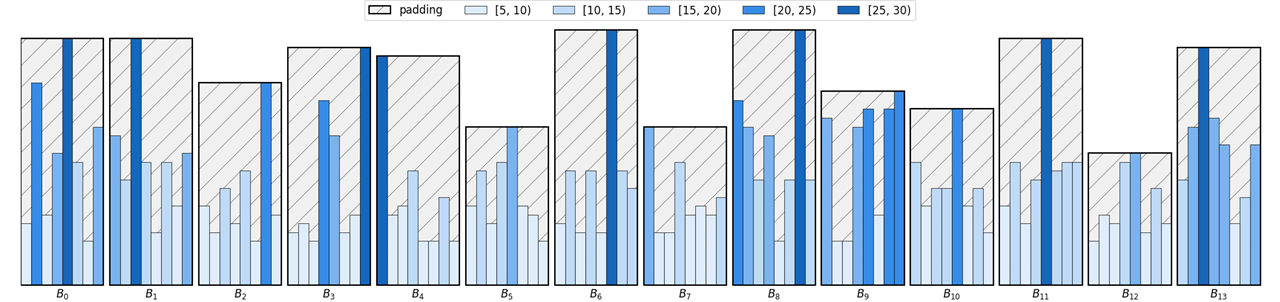

**<center> Figure 1. Bucketing을 적용하지 않은 경우 </center><br><br><br>**

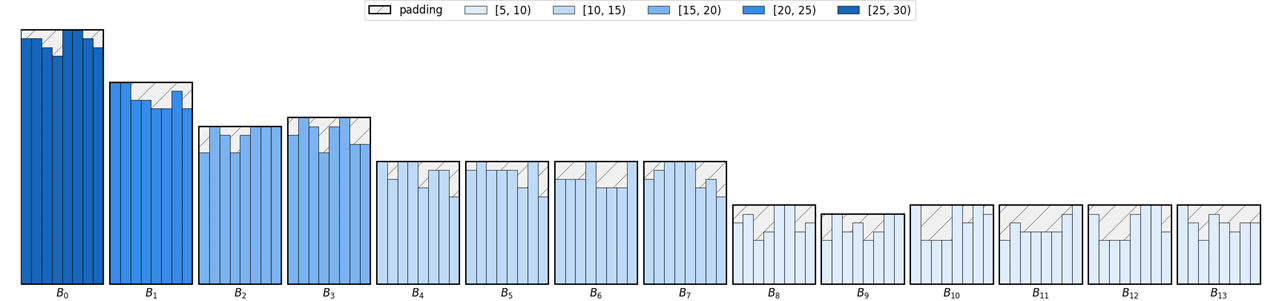

**<center> Figure 2. Bucketing을 적용한 경우 </center>**

In [14]:
def bucketed_batch_indices(
    sentence_length: List[Tuple[int, int]],
    batch_size: int,
    max_pad_len: int
) -> List[List[int]]:
    """ Function for bucketed batch indices
    Although the loss calculation does not consider PAD tokens,
    it actually takes up GPU resources and degrades performance.
    Therefore, the number of <PAD> tokens in a batch should be minimized in order to maximize GPU utilization.
    Implement a function which groups samples into batches that satisfy the number of needed <PAD> tokens in each sentence is less than or equals to max_pad_len.
    
    Note 1: several small batches which have less samples than batch_size are okay but should not be many. If you pass the test, it means "okay".

    Note 2: you can directly apply this function to torch.utils.data.dataloader.DataLoader with batch_sampler argument.
    Read the test codes if you are interested in.

    Arguments:
    sentence_length -- list of (length of source_sentence, length of target_sentence) pairs.
    batch_size -- batch size
    max_pad_len -- maximum padding length. The number of needed <PAD> tokens in each sentence should not exceed this number.

    return:
    batch_indices_list -- list of indices to be a batch. Each element should contain indices of sentence_length list.

    Example:
    If sentence_length = [7, 4, 9, 2, 5, 10], batch_size = 3, and max_pad_len = 3,
    then one of the possible batch_indices_list is [[0, 2, 5], [1, 3, 4]]
    because [0, 2, 5] indices has simialr length as sentence_length[0] = 7, sentence_length[2] = 9, and sentence_length[5] = 10.
    """
    
    ### 아래에 코드 빈칸(None)을 완성해주세요
    batch_map = defaultdict(list)
    batch_indices_list = []
    
    src_len_min = min(sentence_length, key=lambda x : x[0])[0] # 첫번째 인덱스인 src의 min length
    tgt_len_min = min(sentence_length, key=lambda x : x[1])[1] # 두번째 인덱스인 tgt의 min length

    for idx, (src_len, tgt_len) in enumerate(sentence_length): # (jy)완벽한 정렬이 아니라, 일정 범위의 max_pad_len을 공유하는 애들끼리 딕셔너리에 저장한 것. 이후 배치크기로 쪼개기만 하면 됨
        src = (src_len - src_len_min + 1) // (max_pad_len) # max_pad_len 단위로 묶어주기 위한 몫 (그림에서는 5)
        tgt = (tgt_len - tgt_len_min + 1) // (max_pad_len) # max_pad_len 단위로 묶어주기 위한 몫 (그림에서는 5)
        batch_map[(src, tgt)].append(idx)
    # print('sentence length',sentence_length) # (jy) 10~30 사이의 길이 randint로 뽑음 -> (src_len,tgt_len)으로 쓰겠다
    # print('batch_ma_itmes',batch_map.items())
    # print('batch_ma_keys',batch_map.keys())

    for key, value in batch_map.items():
        batch_indices_list += [value[i: i+batch_size] for i in range(0, len(value), batch_size)]
    # print('batch_indices_list',batch_indices_list)

    ### 코드 작성 완료

    # Don't forget shuffling batches because length of each batch could be biased
    random.shuffle(batch_indices_list)

    return batch_indices_list

### 2-1. Bucketing 테스트 케이스 확인

In [15]:
def test_bucketing():
    print ("======Bucketing Test Case======")
    dataset_length = 50000
    min_len = 10
    max_len = 30
    batch_size = 64
    max_pad_len = 5

    sentence_length = [(random.randint(min_len, max_len), random.randint(min_len, max_len))
                       for _ in range(dataset_length)]
    batch_indices = bucketed_batch_indices(sentence_length, batch_size=batch_size,
                                           max_pad_len=max_pad_len)
    
    # the first test
    assert sorted(chain(*batch_indices)) == list(range(0, dataset_length)), \
        "중복되거나 빠진 샘플이 존재합니다."
    print("첫번째 테스트 케이스를 통과했습니다!")
    
    # the second test
    assert sum(1 for batch in batch_indices if len(batch) < batch_size) < 30, \
        "Batch size보다 작은 batch들이 너무 많습니다."
    print("두번째 테스트 케이스를 통과했습니다!")

    # the third test
    for batch in batch_indices:
        src_length, tgt_length = zip(*list(sentence_length[idx] for idx in batch))
        assert max(src_length) - min(src_length) <= max_pad_len and max(tgt_length) - min(tgt_length) <= max_pad_len, \
            "max_pad_len보다 더 많은 <PAD> token이 있는 문장이 있습니다."
    print("세번째 테스트 케이스를 통과했습니다!")

    print("모든 테스트 케이스를 통과했습니다!")
test_bucketing()

======Bucketing Test Case======
sentence length [(30, 11), (22, 12), (26, 11), (12, 30), (24, 17), (21, 24), (18, 20), (21, 21), (16, 29), (24, 30), (29, 19), (25, 18), (21, 30), (29, 20), (11, 15), (19, 26), (16, 24), (11, 28), (27, 13), (19, 23), (27, 11), (18, 22), (30, 19), (20, 24), (16, 16), (13, 19), (16, 16), (22, 10), (20, 20), (17, 25), (15, 10), (16, 26), (10, 23), (15, 14), (15, 13), (18, 12), (17, 21), (18, 29), (15, 14), (17, 27), (22, 17), (10, 28), (27, 28), (28, 29), (24, 12), (10, 15), (23, 14), (19, 21), (28, 24), (14, 21), (25, 23), (30, 30), (25, 13), (25, 28), (19, 25), (30, 15), (16, 20), (27, 14), (14, 27), (28, 23), (14, 26), (18, 15), (17, 13), (20, 16), (18, 28), (30, 17), (23, 17), (25, 12), (19, 12), (21, 13), (16, 13), (13, 17), (30, 24), (15, 15), (15, 23), (22, 28), (10, 26), (10, 17), (22, 20), (10, 18), (20, 28), (10, 30), (11, 24), (11, 24), (10, 11), (23, 18), (15, 25), (11, 28), (15, 28), (16, 21), (18, 21), (29, 20), (24, 25), (28, 26), (14, 12), (

## 3. Collate Function
- Collate function은 주어진 데이터셋을 원하는 형태의 batch로 가공하기 위해 사용되는 함수입니다. Batch 단위별로 max sequence length에 맞게 pad token을 추가하고 내림차순으로 정렬하는 collate_fn 함수를 완성해주세요.

In [ ]:
def collate_fn(
    batched_samples: List[Tuple[List[int], List[int]]]
) -> Tuple[torch.Tensor, torch.Tensor]:
    """ Collate function
    Because each sentence has variable length, you should collate them into one batch with <PAD> tokens.
    Implement collate_fn function which collates source/target sentence into source/target batchs appending <PAD> tokens behind
    Meanwhile, for the convenience of latter implementations, you should sort the sentences within a batch by its source sentence length in descending manner.

    Note 1: if you are an expert on time-series data, you may know a tensor of [sequence_length, batch_size, ...] is much faster than [batch_size, sequence_length, ...].
    However, for simple intuitive understanding, let's just use batch_first this time.

    Note 2: you can directly apply this function to torch.utils.data.dataloader.DataLoader with collate_fn argument.
    Read the test codes if you are interested in.

    Hint: torch.nn.utils.rnn.pad_sequence would be useful

    Arguments:
    batched_samples -- list of (source_sentence, target_sentence) pairs. This list should be converted to a batch

    Return:
    src_sentences -- batched source sentence
                        in shape (batch_size, max_src_sentence_length)
    tgt_sentences -- batched target sentence
                        in shape (batch_size, max_tgt_sentence_length)

    """
    PAD = Language.PAD_TOKEN_IDX
    batch_size = len(batched_samples)
    
    ### 아래에 코드 빈칸을 완성해주세요
    batched_samples = sorted(batched_samples, key=lambda x : x[0], reverse=True) # 0번째 요소의 길이를 기준으로 내림차순 정렬
    
    src_sentences = []
    tgt_sentences = []
    for src_sentence, tgt_sentence in batched_samples:
        src_sentences.append(torch.tensor(src_sentence))
        tgt_sentences.append(torch.tensor(tgt_sentence))

    src_sentences = torch.nn.utils.rnn.pad_sequence(src_sentences, batch_first=True) # batch x longest seuqence 순으로 정렬 (링크 참고)
    tgt_sentences = torch.nn.utils.rnn.pad_sequence(tgt_sentences, batch_first=True) # batch x longest seuqence 순으로 정렬 (링크 참고)
    # 링크: https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pad_sequence.html

    ### 코드 작성 완료

    assert src_sentences.shape[0] == batch_size and tgt_sentences.shape[0] == batch_size
    assert src_sentences.dtype == torch.long and tgt_sentences.dtype == torch.long
    return src_sentences, tgt_sentences

### 3-1. Collate function 테스트 케이스 확인

In [ ]:
def test_collate_fn():
    print("======Collate Function Test Case======")
    
    # the first test
    batched_samples = [([1, 2, 3, 4], [1]), ([1, 2, 3], [1, 2]), ([1, 2], [1, 2, 3]), ([1], [1, 2, 3, 4])]
    src_sentences, tgt_sentences = collate_fn(batched_samples)
    assert (src_sentences == torch.Tensor([[1, 2, 3, 4], [1, 2, 3, 0], [1, 2, 0, 0], [1, 0, 0, 0]])).all() and \
           (tgt_sentences == torch.Tensor([[1, 0, 0, 0], [1, 2, 0, 0], [1, 2, 3, 0], [1, 2, 3, 4]])).all(), \
           "Your collated batch does not math expected result."
    print("첫번째 테스트 케이스를 통과했습니다!")

    # the second test
    batched_samples = [([1], [1, 2, 3, 4]), ([1, 2], [1, 2, 3]), ([1, 2, 3], [1, 2]), ([1, 2, 3, 4], [1])] 
    src_sentences, tgt_sentences = collate_fn(batched_samples)
    assert (src_sentences == torch.Tensor([[1, 2, 3, 4], [1, 2, 3, 0], [1, 2, 0, 0], [1, 0, 0, 0]])).all() and \
           (tgt_sentences == torch.Tensor([[1, 0, 0, 0], [1, 2, 0, 0], [1, 2, 3, 0], [1, 2, 3, 4]])).all(), \
           "Your collated batch should be sorted in descending manner by its source sentence length."
    print("두번째 테스트 케이스를 통과했습니다!")

    print("모든 테스트 케이스를 통과했습니다!")

test_collate_fn()

======Collate Function Test Case======
첫번째 테스트 케이스를 통과했습니다!
두번째 테스트 케이스를 통과했습니다!
모든 테스트 케이스를 통과했습니다!


### 3-2. 전처리 테스트 케이스 확인

In [ ]:
def test_dataloader():
    print("======Dataloader Test======")
    english = Language(['고기를 잡으러 바다로 갈까나', '고기를 잡으러 강으로 갈까나', '이 병에 가득히 넣어가지고요'])
    korean = Language(['Shall we go to the sea to catch fish ?', 'Shall we go to the river to catch fish', 'Put it in this bottle'])
    english.build_vocab()
    korean.build_vocab()
    dataset = NMTDataset(src=english, tgt=korean)

    batch_size = 4
    max_pad_len = 5
    sentence_length = list(map(lambda pair: (len(pair[0]), len(pair[1])), dataset))

    bucketed_batch_indices(sentence_length, batch_size=batch_size, max_pad_len=max_pad_len)   ## 얘 왜 들어있음?
    dataloader = torch.utils.data.dataloader.DataLoader(dataset, collate_fn=collate_fn, num_workers=2, \
                                                        batch_sampler=bucketed_batch_indices(sentence_length, batch_size=batch_size, max_pad_len=max_pad_len))

    src_sentences, tgt_sentences = next(iter(dataloader))
    print("Tensor for Source Sentences: \n", src_sentences)
    print("Tensor for Target Sentences: \n", tgt_sentences)

    print("모든 전처리 과제를 완료했습니다 고생하셨습니다 :)")
test_dataloader()

======Dataloader Test======
Tensor for Source Sentences: 
 tensor([[ 9, 10, 11, 12]])
Tensor for Target Sentences: 
 tensor([[ 2, 14, 15, 16, 17, 18,  3]])
모든 전처리 과제를 완료했습니다 고생하셨습니다 :)
